# Configuring demography
The {class}`~phasegen.distributions.Coalescent` expects a demography object to be passed to it, which can be configured in various ways. When constructing a demography object, you can directly specify the time points at which the population sizes or migration rates change.

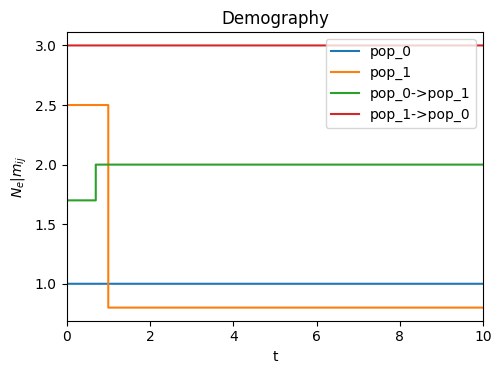

In [8]:
import phasegen as pg

d = pg.Demography(
    pop_sizes={'pop_0': {0: 1}, 'pop_1': {0: 2.5, 1: 0.8}},
    migration_rates={
        ('pop_0', 'pop_1'): {0: 1.7, 0.7: 2},
        ('pop_1', 'pop_0'): {0: 3}
    }
)

d.plot();

Alternatively, you can configure the demography object after construction by adding demographic events. Below, we add {class}`~phasegen.demography.PopSizeChange` and {class}`~phasegen.demography.MigrationRateChange` events to the demography object.

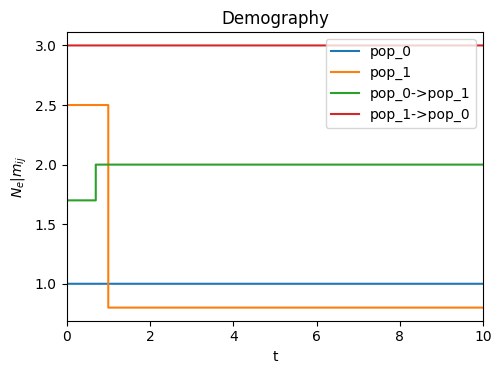

In [9]:
d = pg.Demography()

d.add_event(pg.PopSizeChange(pop='pop_0', time=0, size=1))
d.add_event(pg.PopSizeChange(pop='pop_1', time=0, size=2.5))
d.add_event(pg.PopSizeChange(pop='pop_1', time=1, size=0.8))

d.add_event(pg.MigrationRateChange(source='pop_0', dest='pop_1', time=0, rate=1.7))
d.add_event(pg.MigrationRateChange(source='pop_0', dest='pop_1', time=0.7, rate=2))
d.add_event(pg.MigrationRateChange(source='pop_1', dest='pop_0', time=0, rate=3))

d.plot();

This is similar to the [msprime demography API](https://tskit.dev/msprime/docs/stable/demography.html), and we can easily convert to an msprime demography object. Note that the reverse, converting an msprime demography to a native {class}`~phasegen.demography.Demography` object, is not currently supported due to PhaseGen's inherent restriction to discrete rate changes.

In [10]:
d_msprime = d.to_msprime()

## Discretizing continuous demographies
There are also utilities for discretizing continuous demographies. In the example below, we create a discretized demography by passing a continuous callback function to {class}`~phasegen.demography.DiscretizedRateChange`. You can freely combine this with other demographic events. Note that the total runtime of the coalescent simulation is linear in the number of epochs, i.e., it is roughly a multiple of the number of epochs.

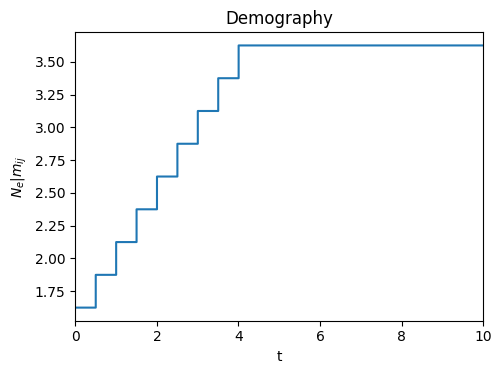

In [11]:
d = pg.Demography(
    events=[
        pg.DiscretizedRateChange(
            trajectory=lambda t: 1.5 + 0.5 * t, 
            pop='pop_0',
            start_time=0, 
            end_time=5, 
            step_size=0.5
        )
    ]
)

d.plot();

For exponential growth or decline, you can also make use of {class}`~phasegen.demography.ExponentialPopSizeChanges`.

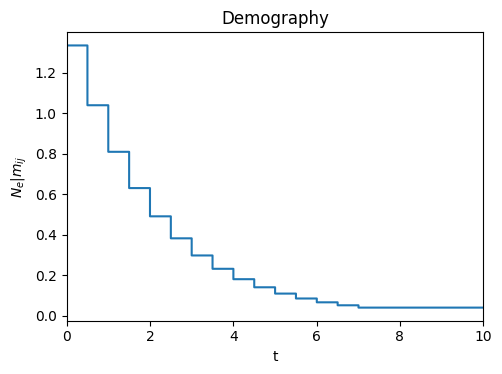

In [12]:
d = pg.Demography(
    events=[
        pg.ExponentialPopSizeChanges(
            initial_size={'pop_0': 1.5}, 
            growth_rate=0.5, 
            start_time=0, 
            end_time=8, 
            step_size=0.5
        )
    ]
)

d.plot();